In [2]:
import pandas as pd
import seaborn as sns 
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import numpy as np


In [3]:
df = pd.read_csv('final_good.csv')

df['CO2 Emissions (g)'] = df['CO2 Emissions (kg)'] * 1000

df = df.drop('CO2 Emissions (kg)', axis = 1)

df.head()

,Flight ID,Aircraft Type,Departure Airport,Arrival Airport,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
0,F0001,Boeing 777,LHR,MUC,2917,4.16,36890,116,36,0.088447,0.911553,27629,126,6349,82695940.0
1,F0002,Boeing 777,EDI,MXP,1067,1.38,31966,8,8,0.010645,0.989355,24324,346,9564,61440550.0
2,F0003,Boeing 787,BLQ,BCN,11180,16.11,30009,64,3,0.006474,0.993526,25948,162,5351,82779520.0
3,F0004,Airbus A350,FRA,LYS,6851,7.85,33703,49,0,0.021204,0.978796,33677,247,8512,92117270.0
4,F0005,Boeing 777,NAP,LHR,8087,10.01,37432,81,-10,0.070372,0.929628,22371,234,7284,66366410.0


In [4]:
print("Missing values per column:")
print(df.isnull().sum())

print("Summary statistics:")
print(df.describe())

Missing values per column:
Flight ID                    0
Aircraft Type                0
Departure Airport            0
Arrival Airport              0
Distance (km)                0
Duration (hours)             0
Cruising Altitude (ft)       0
Wind Speed (km/h)            0
Temperature (°C)             0
SAF Percentage               0
Jet A-1 Percentage           0
Fuel Consumption (liters)    0
Passenger Load               0
Cargo Load (kg)              0
CO2 Emissions (g)            0
dtype: int64
Summary statistics:
       Distance (km)  Duration (hours)  Cruising Altitude (ft)  \
count    2500.000000       2500.000000             2500.000000   
mean     6111.757600          8.273548            35560.153600   
std      3378.397483          4.700575             3251.916066   
min       302.000000          0.360000            30001.000000   
25%      3238.000000          4.347500            32673.500000   
50%      6019.000000          8.020000            35610.500000   
75%      9064

## Checking for outliers


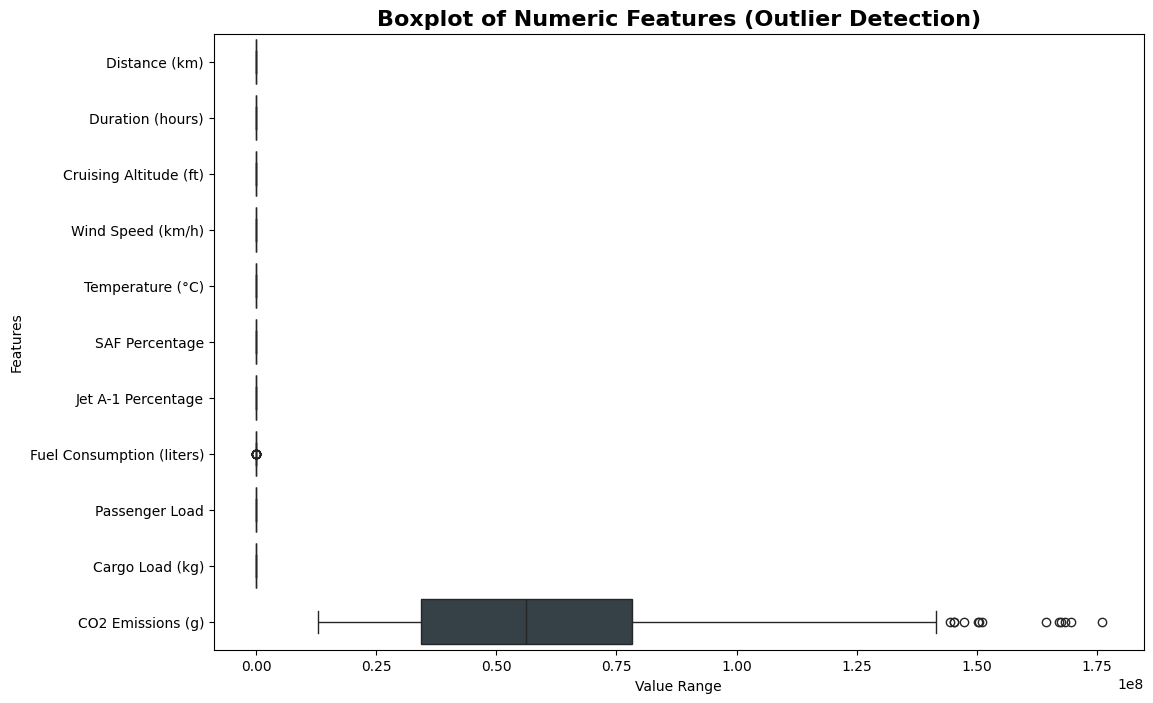

In [5]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_cols], orient="h", palette="Blues_d")

plt.title('Boxplot of Numeric Features (Outlier Detection)', fontsize=16, weight='bold')
plt.xlabel('Value Range')
plt.ylabel('Features')
plt.show()

In [6]:
for col in numeric_cols:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
print(df.describe())

       Distance (km)  Duration (hours)  Cruising Altitude (ft)  \
count    2500.000000       2500.000000             2500.000000   
mean     6111.669500          8.268535            35560.322000   
std      3376.749319          4.686004             3250.245827   
min       382.980000          0.519900            30104.950000   
25%      3238.000000          4.347500            32673.500000   
50%      6019.000000          8.020000            35610.500000   
75%      9064.500000         12.052500            38445.500000   
max     11891.010000         18.350000            40923.050000   

       Wind Speed (km/h)  Temperature (°C)  SAF Percentage  \
count        2500.000000       2500.000000     2500.000000   
mean           59.399600         12.729600        0.040395   
std            34.469476         16.091988        0.032542   
min             1.000000        -15.000000        0.000000   
25%            31.000000         -1.000000        0.007483   
50%            59.000000         

In [7]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.head()

,Flight ID,Aircraft Type,Departure Airport,Arrival Airport,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
0,F0001,Boeing 777,LHR,MUC,-0.946268,-0.876943,0.409183,1.642373,1.446375,1.476912,-1.476912,0.800060,-0.837213,0.040149,0.990429
1,F0002,Boeing 777,EDI,MXP,-1.494241,-1.470317,-1.106083,-1.491461,-0.293969,-0.914366,0.914366,0.436985,1.662609,1.029772,0.169471
2,F0003,Boeing 787,BLQ,BCN,1.501250,1.673715,-1.678785,0.133490,-0.604745,-1.042571,1.042571,0.615392,-0.428151,-0.267050,0.993657
3,F0004,Airbus A350,FRA,LYS,0.218991,-0.089334,-0.571555,-0.301765,-0.791210,-0.589835,0.589835,1.464471,0.537689,0.705951,1.354314
4,F0005,Boeing 777,NAP,LHR,0.585097,0.371705,0.575973,0.626778,-1.412762,0.921356,-0.921356,0.222436,0.389972,0.327955,0.359725


In [14]:

non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['Flight ID', 'Aircraft Type', 'Departure Airport', 'Arrival Airport'], dtype='object')


In [15]:
df_encoded = pd.get_dummies(df, columns=non_numeric_cols)

print(df_encoded.head())


   Distance (km)  Duration (hours)  Cruising Altitude (ft)  Wind Speed (km/h)  \
0      -0.946268         -0.876943                0.409183           1.642373   
1      -1.494241         -1.470317               -1.106083          -1.491461   
2       1.501250          1.673715               -1.678785           0.133490   
3       0.218991         -0.089334               -0.571555          -0.301765   
4       0.585097          0.371705                0.575973           0.626778   

   Temperature (°C)  SAF Percentage  Jet A-1 Percentage  \
0          1.446375        1.476912           -1.476912   
1         -0.293969       -0.914366            0.914366   
2         -0.604745       -1.042571            1.042571   
3         -0.791210       -0.589835            0.589835   
4         -1.412762        0.921356           -0.921356   

   Fuel Consumption (liters)  Passenger Load  Cargo Load (kg)  ...  \
0                   0.800060       -0.837213         0.040149  ...   
1                 

In [17]:
X = df_encoded.drop('CO2 Emissions (g)', axis=1)
y = df_encoded['CO2 Emissions (g)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


rmse_scorer = make_scorer(rmse, greater_is_better=False)


param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}

# Ridge Regression
ridge = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                                 scoring=rmse_scorer, cv=5, n_jobs=-1, verbose=1)
grid_search_ridge.fit(X_train, y_train)



# Print the best parameters and RMSE for Ridge and Lasso
print("Best Ridge alpha:", grid_search_ridge.best_params_)
print("Best Ridge RMSE:", -grid_search_ridge.best_score_)




Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge alpha: {'alpha': 10}
Best Ridge RMSE: 0.17466825513664333


In [20]:

best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test)


rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge Regression Test RMSE: {rmse_test_ridge}")



Ridge Regression Test RMSE: 0.16800056599140364


## Cross Validation for Ridge Regression

In [39]:
ridge = Ridge(alpha=grid_search_ridge.best_params_['alpha'])


cv_scores = cross_val_score(ridge, X_train, y_train, scoring=rmse_scorer, cv=5)

mean_cv_rmse = -cv_scores.mean()

std_cv_rmse = cv_scores.std()

print(f"Mean Cross-Validation RMSE: {mean_cv_rmse}")


Mean Cross-Validation RMSE: 0.1746682551366434


## Iteration, comparing other model with baseline model. 

### Random Forest Regressor

In [25]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 0.1731273925117674


### Gradient Boosting Regressor 

In [26]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"Gradient Boosting RMSE: {rmse_gb}")

Gradient Boosting RMSE: 0.16683474820387145


### XGBoost Regressor

In [27]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 0.17276081753654216


### Cross - validation for random forest

In [38]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

rf_mean_cv_rmse = -rf_cv_scores.mean()
rf_std_cv_rmse = rf_cv_scores.std()


print(f"Random Forest Cross-Validation RMSE: {rf_mean_cv_rmse:.4f}")


Random Forest Cross-Validation RMSE: 0.1788


### Cross validation for Gradient Boostin

In [37]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

gb_mean_cv_rmse = -gb_cv_scores.mean()
gb_std_cv_rmse = gb_cv_scores.std()

print(f"Gradient Boosting Cross-Validation RMSE: {gb_mean_cv_rmse:.4f}")


Gradient Boosting Cross-Validation RMSE: 0.1731


### Cross validation fro XGBoost

In [36]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

xgb_mean_cv_rmse = -xgb_cv_scores.mean()
xgb_std_cv_rmse = xgb_cv_scores.std()

print(f"XGBoost Cross-Validation RMSE: {xgb_mean_cv_rmse:.4f}")


XGBoost Cross-Validation RMSE: 0.1825


## Comparing all the models

In [45]:
rmse_data = {
    "Model": ["Ridge Regression", "Random Forest", "Gradient Boosting", "XGBoost"],
    "RMSE": [rmse_test_ridge, rmse_rf, rmse_gb, rmse_xgb],
    'RMSE_CV':[mean_cv_rmse, rf_mean_cv_rmse, gb_mean_cv_rmse, xgb_mean_cv_rmse]
}

rmse_df = pd.DataFrame(rmse_data)


rmse_df

,Model,RMSE,RMSE_CV
0,Ridge Regression,0.168001,0.174668
1,Random Forest,0.173127,0.178789
2,Gradient Boosting,0.166835,0.173064
3,XGBoost,0.172761,0.182512


## plotting the actuall vs Predicted scores. 

In [58]:
y_test_sorted = np.sort(y_test)
y_test_sorted_index = next(i for i, x in enumerate(y_test_sorted) if x > 0)
y_test_sorted_index

258

In [64]:
y_pred_sorted_gb = np.sort(y_pred_gb)
y_pred_sorted_gb_index = next(i for i, x in enumerate(y_pred_sorted_gb) if x > 0)
y_pred_sorted_gb_index

248

In [66]:
split_index = max(y_test_sorted_index, y_pred_sorted_gb_index)

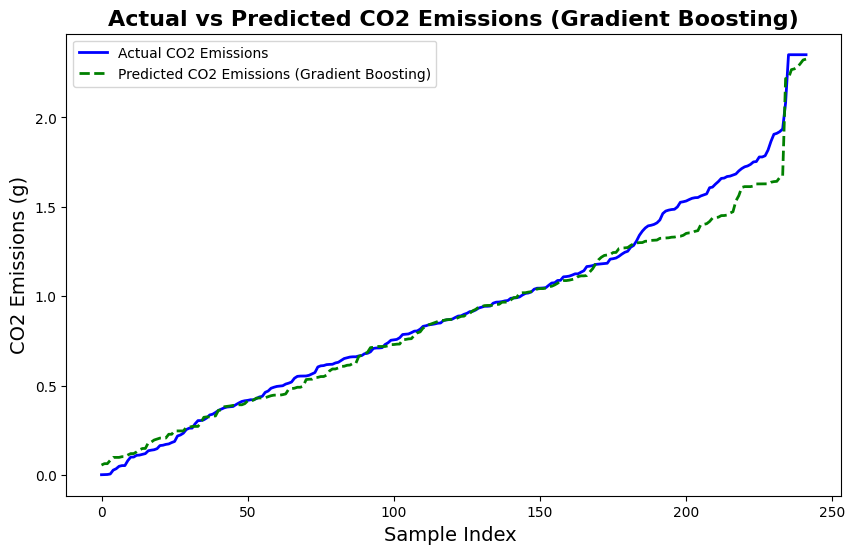

In [67]:
y_test_sorted = y_test_sorted[split_index:]
y_pred_sorted_gb = y_pred_sorted_gb[split_index:]

plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label="Actual CO2 Emissions", color='blue', linewidth=2)
plt.plot(y_pred_sorted_gb, label="Predicted CO2 Emissions (Gradient Boosting)", color='green', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted CO2 Emissions (Gradient Boosting)', fontsize=16, weight='bold')
plt.xlabel('Sample Index ', fontsize=14)
plt.ylabel('CO2 Emissions (g)', fontsize=14)
plt.legend()
plt.show()


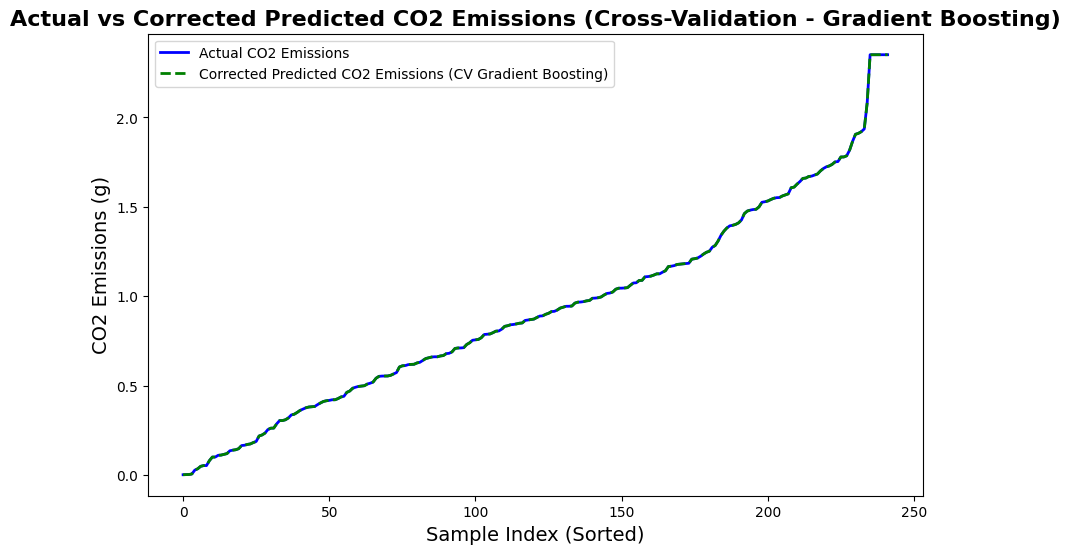

In [69]:
import numpy as np

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
y_pred_cv_gb = cross_val_predict(gb_model, X, y, cv=5)  

y_pred_cv_gb_corrected = np.maximum(y_pred_cv_gb, 0)


y_sorted = np.sort(y) 
y_pred_cv_gb_sorted_corrected = np.sort(y_pred_cv_gb_corrected)  

y_sorted = np.sort(y_test)
y_sorted_index = next(i for i, x in enumerate(y_sorted) if x > 0)

y_pred_cv_gb_sorted_corrected = np.sort(y_test)
y_pred_cv_gb_sorted_corrected_index = next(i for i, x in enumerate(y_pred_cv_gb_sorted_corrected) if x > 0)

split_index = max(y_sorted_index, y_pred_cv_gb_sorted_corrected_index)
y_sorted = y_sorted[split_index:]  
y_pred_cv_gb_sorted_corrected = y_pred_cv_gb_sorted_corrected[split_index:]



plt.figure(figsize=(10, 6))
plt.plot(y_sorted, label="Actual CO2 Emissions", color='blue', linewidth=2)
plt.plot(y_pred_cv_gb_sorted_corrected, label="Corrected Predicted CO2 Emissions (CV Gradient Boosting)", color='green', linestyle='--', linewidth=2)


plt.title('Actual vs Corrected Predicted CO2 Emissions (Cross-Validation - Gradient Boosting)', fontsize=16, weight='bold')
plt.xlabel('Sample Index (Sorted)', fontsize=14)
plt.ylabel('CO2 Emissions (g)', fontsize=14)
plt.legend()
plt.show()


## Plotting the actual vs predicted score after cross validation 

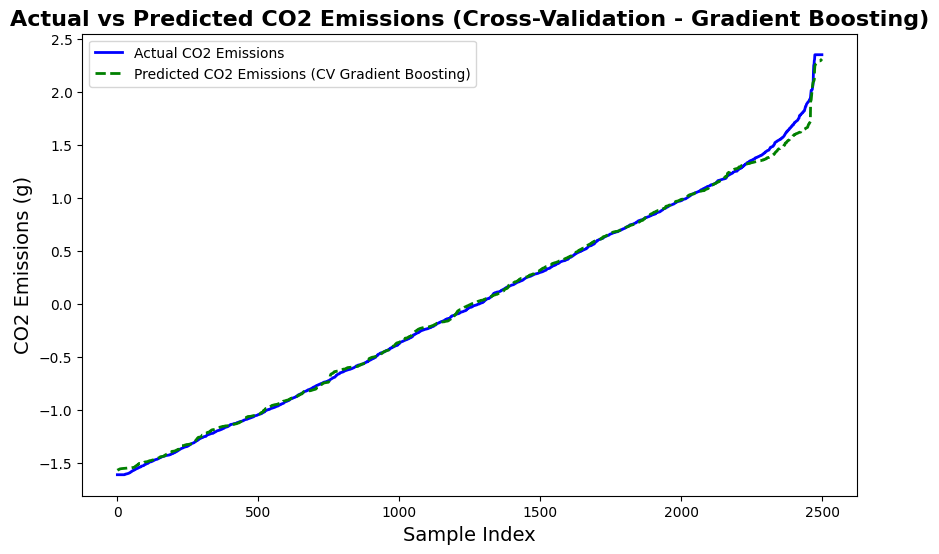

In [52]:


gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
y_pred_cv_gb = cross_val_predict(gb_model, X, y, cv=5)  


y_sorted = np.sort(y)  
y_pred_cv_gb_sorted = np.sort(y_pred_cv_gb)  


plt.figure(figsize=(10, 6))


if len(y_pred_cv_gb_sorted) == len(y_sorted):
    plt.plot(y_sorted, label="Actual CO2 Emissions", color='blue', linewidth=2)
    plt.plot(y_pred_cv_gb_sorted, label="Predicted CO2 Emissions (CV Gradient Boosting)", color='green', linestyle='--', linewidth=2)
else:
    print("Warning: Mismatch in length between actual and predicted values.")


plt.title('Actual vs Predicted CO2 Emissions (Cross-Validation - Gradient Boosting)', fontsize=16, weight='bold')
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('CO2 Emissions (g)', fontsize=14)
plt.legend()
plt.show()


## MLFlow Logging 

In [29]:
MLFLOW_TRACKING_URI = "http://127.0.0.1:8080"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [30]:
with mlflow.start_run(run_name="Model Comparison"):
    mlflow.log_metric("Ridge Regression RMSE", rmse_test_ridge)
    mlflow.sklearn.log_model(rmse_test_ridge, "Ridge Regression Model")
    
    mlflow.log_metric("Random Forest RMSE", rmse_rf)
    mlflow.sklearn.log_model(rf_model, "Random Forest Model")
    
    mlflow.log_metric("Gradient Boosting RMSE", rmse_gb)
    mlflow.sklearn.log_model(gb_model, "Gradient Boosting Model")
    
    mlflow.log_metric("XGBoost RMSE", rmse_xgb)
    mlflow.sklearn.log_model(xgb_model, "XGBoost Model")
    
    rmse_df.to_csv("rmse_comparison.csv", index=False)
    mlflow.log_artifact("rmse_comparison.csv")
    
print("Model metrics and artifacts logged in MLflow.")
    
    
    


MlflowException: API request to http://127.0.0.1:8080/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002C34AE22300>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))